## Introduction Examples

In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
from sklearn.utils.random import sample_without_replacement
from imblearn.under_sampling import RandomUnderSampler

N = 100000
X, y = make_blobs(n_samples=N, n_features=2, centers=[[0, 0]], cluster_std=3, random_state=2)
mins = X.min(axis=0)
maxs = X.max(axis=0)

def add_noise(X, y):
  X2 = np.random.rand(int(N * 0.2), 2)
  y2 = np.full(int(N * 0.2), -1)
  X2[:, 0] = (X2[:, 0] * (maxs[0] - mins[0])) + mins[0]
  X2[:, 1] = (X2[:, 1]) * (maxs[1] - mins[1]) + mins[1]

  X_ = np.concatenate([X, X2], axis=0)
  y_ = np.concatenate([y, y2], axis=0)
  return X_, y_

X, y = add_noise(X, y)


def cluster(X, y):
  clustering = DBSCAN(eps=0.32, min_samples=100).fit(X)
  c = clustering.labels_
  return c


def to_df(X, y):
  df = pd.DataFrame(X, columns=["A, B"])
  df["y"] = y
  return df


def draw_uniform_sample(X, y, n_sample: int):
  # shuffle the input data
  random = np.random.rand(len(X))
  random_order = np.argsort(random)
  X_ = X[random_order]

  # draw random sample
  sample = sample_without_replacement(n_population=len(X_), n_samples=n_sample, random_state=0)

  return to_df(X[sample], y[sample])


def draw_inlier_sample(X, y, n_sample: int):
  # dbscan: -1 is outlier, so inlier is > -1
  c = cluster(X, y)
  c = (c > -1).astype(int)

  # in case there are more than n_sample inliers, sample down uniformly
  return draw_uniform_sample(X[c == 1], c[c == 1], n_sample=n_sample)


def draw_stratified_sample(X, y, n_sample: int):
  c = cluster(X, y)
  c = (c > -1).astype(int)
  
  # clustering might find more than 2 clusters, but all we need is inlier/outliere(int)

  rus = RandomUnderSampler()
  X_, y_ = rus.fit_resample(X, c)
  return draw_uniform_sample(X_, y_, n_sample=n_sample)


def draw_noise_sample(X, y, n_sample: int):
  c = cluster(X, y)
  c = (c > -1).astype(int)
  
  return draw_uniform_sample(X[y == -1], c[y == -1], n_sample)


def draw_outlier_sample(X, y, n_sample: int):
  # dbscan: -1 is outlier, so inlier is > -1
  c = cluster(X, y).astype(int)

  return draw_uniform_sample(X[c == -1], c[c == -1], n_sample)

### Different sampling tasks on the same dataset

(-12.48393401358247, 14.190341438793237)

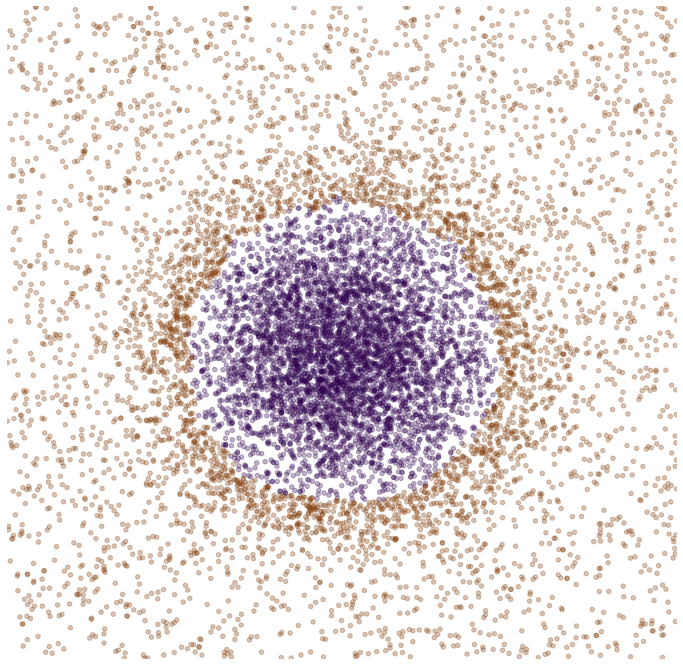

In [3]:
# plot a sampling
# df = draw_noise_sample(X, y, 10000)
df = draw_stratified_sample(X, y, 10000)
# df = draw_outlier_sample(X, y, 10000)
# df = draw_inlier_sample(X, y, 10000)
# df = draw_uniform_sample(X, y, 10000)

plt = df.plot.scatter(
  x="A", 
  y="B", 
  # c="#2f124b", 
  c="y",
  colormap="PuOr", 
  alpha=0.3, 
  figsize=[12, 12], 
  colorbar=False,
)

plt.axis("off")
plt.set_xlim([mins[0], maxs[0]])
plt.set_ylim([mins[1], maxs[1]])

(-12.48393401358247, 14.190341438793237)

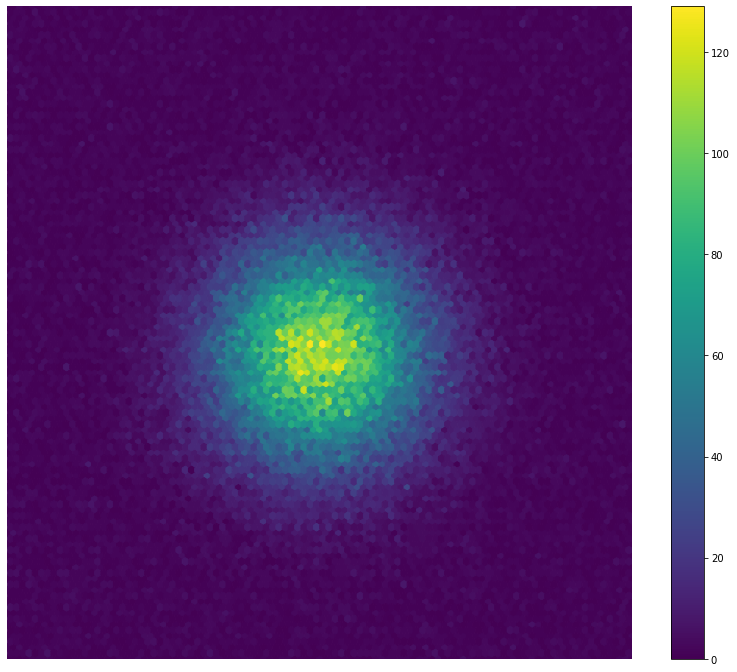

In [4]:
# plot the original dataset
df = pd.DataFrame(X, columns=["A, B"])
plt = df.plot.hexbin(
  x='A',
  y='B',
  reduce_C_function=np.sum,
  gridsize=100,
  cmap="viridis",
  figsize=[14, 12],
)

plt.axis("off")
plt.set_xlim([mins[0], maxs[0]])
plt.set_ylim([mins[1], maxs[1]])

### Sampling the same dataset by different data types

In [148]:
import pandas as pd
from datetime import datetime

# source 2018 yellow cab taxi rides (112M lines):
# https://data.cityofnewyork.us/Transportation/2018-Yellow-Taxi-Trip-Data/t29m-gskq
# source taxi zones:
# https://data.cityofnewyork.us/Transportation/NYC-Taxi-Zones/d3c5-ddgc
rides_df = pd.read_csv("./linearizations/input_files/taxis.csv", delimiter=", ")
zones_df = pd.read_csv("./linearizations/input_files/taxi_zones.csv")

pd.to_datetime(rides_df["tpep_pickup_datetime"].loc[:100]).max()

Timestamp('2018-12-30 19:48:43')

NameError: name 'rides_df' is not defined

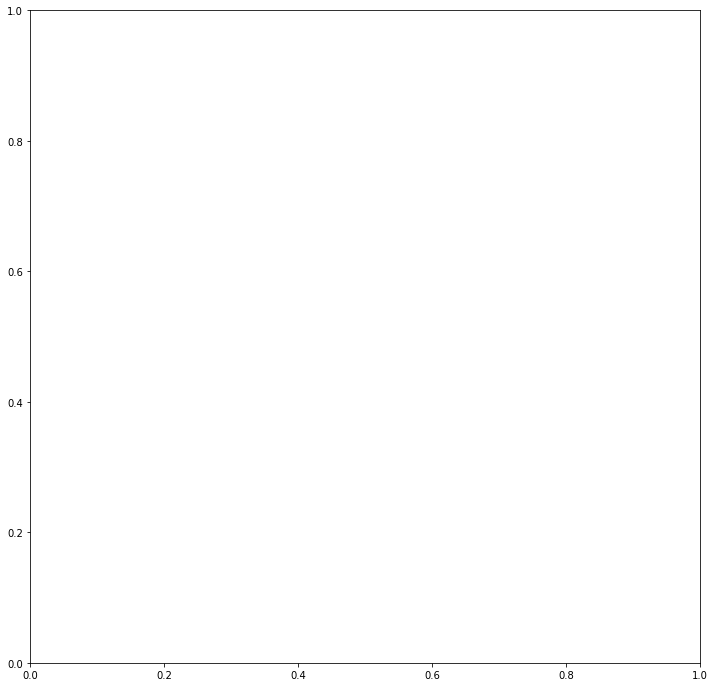

In [2]:
# plot the rides dataset in hexbinned histogram
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)

image = plt.hexbin(
  x=rides_df["PURepresentativeX"], 
  y=rides_df["PURepresentativeY"],
  bins="log",
  mincnt=1,
  gridsize=45,
)

plt.grid(True, )
image.get_array()

### Linearize the dataset by three different data types

In [23]:
import pandas as pd
from linearizations.Linearization import LinearizationDatetimeAttr, LinearizationNumericAttr, LinearizationGeoZorder

lin1 = LinearizationDatetimeAttr("taxis", 25, 2)  # sort by pickup date
lin1_data = lin1.linearize()

lin2 = LinearizationNumericAttr("taxis", 25, 5)  # sort by trip distance
lin2_data = lin2.linearize()

lin3 = LinearizationGeoZorder("taxis", 25, 20, 19)  # sort by pickup location
lin3_data = lin3.linearize()

Linearized file into folder output_files
Linearized file into folder output_files
Linearized file into folder output_files


### Sample geospace (pick-up location)

       tripID  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
15978   39359         2  2018-01-16 12:08:35   2018-01-16 12:48:06   
15979  797941         1  2018-12-07 13:43:58   2018-12-07 13:52:40   
15980  283357         2  2018-06-15 10:32:49   2018-06-15 10:46:33   
15981  529618         1  2018-09-26 22:51:19   2018-09-26 23:06:15   
15982  569538         2  2018-09-24 22:27:15   2018-09-24 22:42:22   
...       ...       ...                  ...                   ...   
16973  804262         1  2018-08-12 13:37:42   2018-08-12 13:48:17   
16974  102130         2  2018-10-28 10:49:07   2018-10-28 11:19:47   
16975   43236         2  2018-12-14 14:25:42   2018-12-14 14:41:42   
16976  288481         1  2018-09-07 18:52:32   2018-09-07 18:58:02   
16977   88468         2  2018-07-11 11:37:37   2018-07-11 12:03:51   

       passenger_count  trip_distance  RatecodeID store_and_fwd_flag  \
15978                6          20.25           2                  N   
15979          

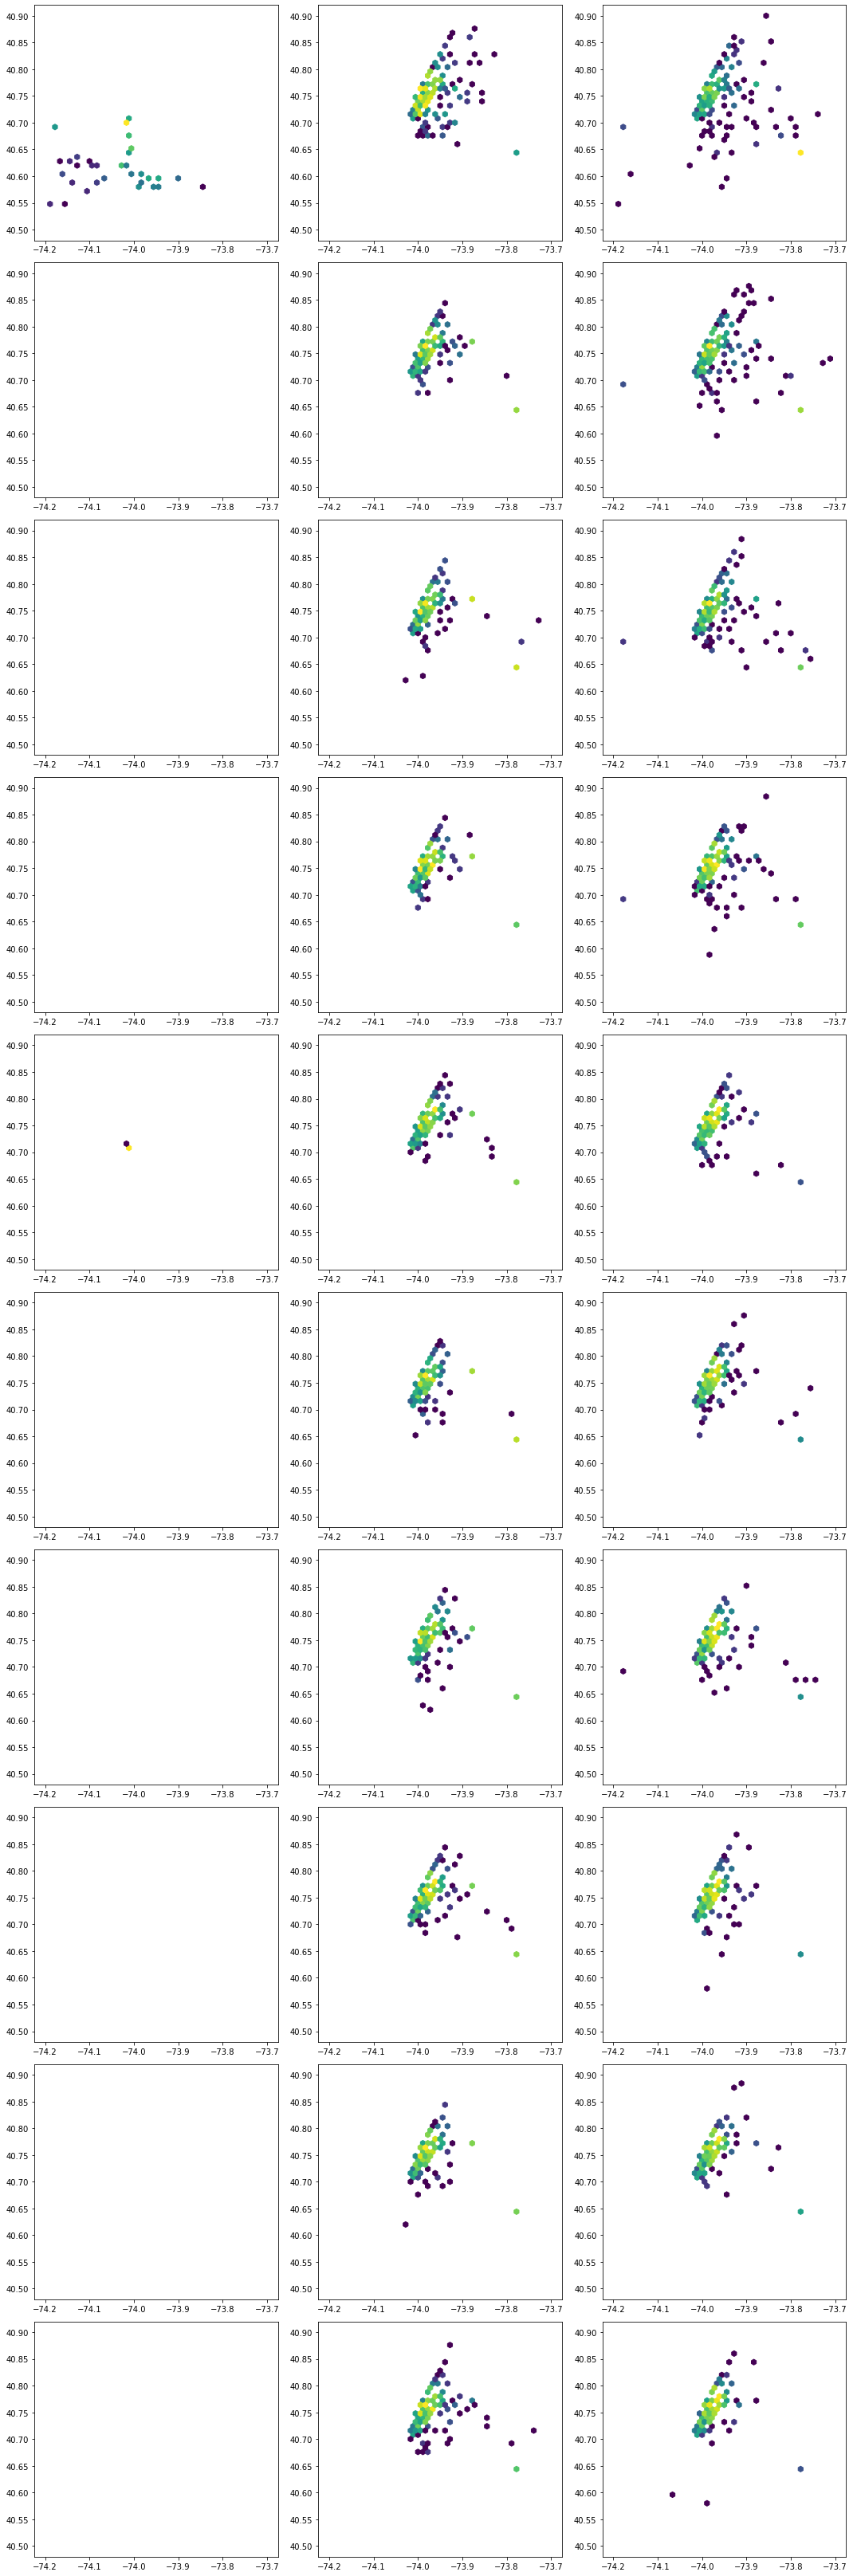

In [83]:
# plot the rides dataset in hexbinned histogram
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# read the linearization 
header = ["tripID", "VendorID", "tpep_pickup_datetime", "tpep_dropoff_datetime", "passenger_count", "trip_distance", "RatecodeID", "store_and_fwd_flag", "PULocationID", "DOLocationID", "payment_type", "fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "total_amount", "PUZone", "PURepresentativeX", "PURepresentativeY", "DOZone", "DORepresentativeX", "DORepresentativeY"]

fig, ax = plt.subplots(10, 3, figsize=(15, 45))

df_geo = pd.read_csv("./linearizations/output_files/taxisLinearizationGeoZorder.csv", delimiter=";", names=header)
df_temp = pd.read_csv("./linearizations/output_files/taxisLinearizationSortByTempAttr.csv", delimiter=";", names=header)
df_dist = pd.read_csv("./linearizations/output_files/taxisLinearizationSortByNumAttr.csv", delimiter=";", names=header)

def plot(df: pd.DataFrame, n_sample: int, ax: int, i: int):
  # get first n points
  sample = df[df["PURepresentativeX"].notnull() & df["PURepresentativeY"].notnull()].iloc[i * n_sample:(i+1) * n_sample]

  ax.hexbin(
    x=sample["PURepresentativeX"], 
    y=sample["PURepresentativeY"],
    bins="log",
    mincnt=1,
    gridsize=45,
    extent=[-74.2, -73.7, 40.5, 40.9]
  )

n_samples = 1000
for i in range(10):
  plot(df_geo, n_samples, ax[i][0], i)
  plot(df_temp, n_samples, ax[i][1], i)
  plot(df_dist, n_samples, ax[i][2], i)

plt.tight_layout()
plt.show()

### Sample by numerical attribute (trip duration, trip distance, ...)

### Sample by temporal attribute (pickup time, dropoff time, ...)